In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
TRAIN = 'train.csv'
TEST = 'test.csv'

In [3]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

## Функция для оптимизации фалов

In [4]:
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [5]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [7]:
train.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   
5  12915          59    3.0  80.384479   46.683720           12.0      5   
6  14549         154    2.0  62.254114   37.160377            7.0      3   
7  11993          74    2.0  80.312926         NaN            0.0     14   
8   5172           1    2.0  64.511437         NaN            1.0      9   
9   8649          23    1.0  46.461409   18.915552            8.0     13   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   
5        17.0       2011   0.309479         B         B        35      7715   
6         5.0       1960   0.460556         B         B        20      4386   
7         0.0       1977   0.075779         B         B         6      1437   
8        17.0       1977   0.007122         B         B         1       264   
9        17.0       2014   0.075779         B         B         6      1437   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644  
5         4         990.0            0        6       B  215898.447742  
6        14           NaN            1        5       B  296021.204377  
7         3           NaN            0        2       B  221244.156664  
8         0           NaN            0        1       B  229102.795999  
9         3           NaN            0        2       B   95380.220993

In [8]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = train['HouseFloor'].astype('int64')
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = train['Rooms'].astype('int64')

исправим название колонки:

In [9]:
train.rename(columns = {'Helthcare_2':'Healthcare_2'}, inplace = True)
test.rename(columns = {'Helthcare_2':'Healthcare_2'}, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  int64  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Опитимизируем оба файла:

In [10]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [11]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Healthcare_2   10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [12]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Healthcare_2   5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

Значительно уменьшили вес файлов. 420.6 KB вместо 3.1 MB и 181.4 KB вместо 1.5 MB

In [13]:
data = pd.concat((train, test), sort=False).reset_index(drop=True)
data.drop(['Price'], axis=1, inplace=True)

In [14]:
data.describe().transpose()

count         mean            std          min          25%  \
Id             15000.0  8393.136933    4850.111673     0.000000  4188.750000   
DistrictId     15000.0    50.693600      43.786257     0.000000    20.000000   
Rooms          15000.0     1.892867       0.845835     0.000000     1.000000   
Square         15000.0    56.360546      20.423899     1.136859    41.814370   
LifeSquare     11846.0    36.851711      71.120201     0.333490    22.896130   
KitchenSquare  15000.0     6.174467      24.017548     0.000000     1.000000   
Floor          15000.0     8.561800       5.323113     1.000000     4.000000   
HouseFloor     15000.0    12.587067       6.721634     0.000000     9.000000   
HouseYear      15000.0  3321.575067  163707.780381  1908.000000  1974.000000   
Ecology_1      15000.0     0.119195       0.119371     0.000000     0.017647   
Social_1       15000.0    24.769267      17.532278     0.000000     6.000000   
Social_2       15000.0  5370.404933    4013.364403   168.000000  1564.000000   
Social_3       15000.0     8.113667      23.841946     0.000000     0.000000   
Healthcare_1    7825.0  1144.162476    1029.307373     0.000000   350.000000   
Healthcare_2   15000.0     1.319467       1.489012     0.000000     0.000000   
Shops_1        15000.0     4.235133       4.796545     0.000000     1.000000   

                       50%           75%           max  
Id             8378.500000  12594.250000  1.679800e+04  
DistrictId       37.000000     75.000000  2.120000e+02  
Rooms             2.000000      2.000000  1.900000e+01  
Square           52.645758     66.036606  6.410652e+02  
LifeSquare       32.822811     45.144627  7.480592e+03  
KitchenSquare     6.000000      9.000000  2.014000e+03  
Floor             7.000000     12.000000  7.800000e+01  
HouseFloor       13.000000     17.000000  1.170000e+02  
HouseYear      1977.000000   2001.000000  2.005201e+07  
Ecology_1         0.075424      0.195781  5.218670e-01  
Social_1         25.000000     36.000000  7.400000e+01  
Social_2       5285.000000   7287.000000  1.908300e+04  
Social_3          2.000000      5.000000  1.410000e+02  
Healthcare_1    900.000000   1548.000000  4.849000e+03  
Healthcare_2      1.000000      2.000000  6.000000e+00  
Shops_1           3.000000      6.000000  2.300000e+01

Проверим все "подозрительные" данные:
#### ROOMS

In [15]:
data.loc[data['Rooms'] == 0]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1397   12638          27      0  138.427689  136.215500            0.0      4   
1981    7917          27      0  212.932358  211.231125            0.0      2   
2269    7317          27      0   41.790882         NaN            0.0     13   
3911     770          28      0   49.483501         NaN            0.0     16   
4366     456           6      0   81.491447         NaN            0.0      4   
4853    3224          27      0    2.377248    0.873147            0.0      1   
6149    3159          88      0   38.697117   19.345131            9.0      9   
8834    9443          27      0   87.762619   85.125473            0.0      5   
11397  15870          44      0   54.300587   33.525097            8.0      2   
11981  10489          62      0   68.936256   36.866276           16.0      6   
12269  15341          13      0   54.409691   33.223633            9.0     11   
13911   8558           1      0   46.517975   46.891521           10.0     24   
14366   2439          48      0   55.088520   33.642242            8.0      4   
14853  15820          88      0   37.013954   23.140297            9.0      9   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1397            3       2016   0.075424         B         B        11   
1981            3       2008   0.211401         B         B         9   
2269            0       1977   0.211401         B         B         9   
3911            0       2015   0.118537         B         B        30   
4366            0       1977   0.243205         B         B         5   
4853            0       1977   0.017647         B         B         2   
6149           16       1982   0.127376         B         B        43   
8834           15       1977   0.211401         B         B         9   
11397           3       1990   0.036122         B         B        24   
11981           3       2012   0.072158         B         B         2   
12269           0       1999   0.090799         B         B        74   
13911           0       2017   0.007122         B         B         1   
14366           0       1981   0.041125         B         B        46   
14853           0       1976   0.127376         B         B        43   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  
1397       3097         0           NaN             0        0       B  
1981       1892         0           NaN             0        1       B  
2269       1892         0           NaN             0        1       B  
3911       6207         1        1183.0             1        0       B  
4366       1564         0         540.0             0        0       B  
4853        469         0           NaN             0        0       B  
6149       8429         3           NaN             3        9       B  
8834       1892         0           NaN             0        1       B  
11397      4378         0        1036.0             1        1       B  
11981       629         1           NaN             0        0       A  
12269     19083         2           NaN             5       15       B  
13911       264         0           NaN             0        1       B  
14366      9515         5           NaN             1       10       B  
14853      8429         3           NaN             3        9       B

In [16]:
data.loc[data['Rooms'] > 5]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
377     5927          57     10  59.056976   36.223072           10.0     22   
1454    8491           1     19  42.006046   21.779287            7.0     17   
2170   14003          99      6  59.414333   38.702244            6.0      7   
8849   14865           9     10  60.871265   38.420681           10.0      3   
10377   3313          48     10  46.874424   29.423719            6.0      2   
11454  12450          53     19  39.475605   38.809181            1.0     11   
12170  10858           6      6  40.732910   38.817303            1.0     17   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
377            22       2002   0.090799         B         B        74   
1454           17       2014   0.007122         B         B         1   
2170            9       1969   0.033494         B         B        66   
8849            2       1994   0.161532         B         B        25   
10377          22       1979   0.041125         B         B        46   
11454          17       2017   0.049637         B         B        34   
12170           9       2014   0.243205         B         B         5   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  
377       19083         2           NaN             5       15       B  
1454        264         0           NaN             0        1       B  
2170      10573         1        1322.0             3        8       B  
8849       5648         1          30.0             2        4       B  
10377      9515         5           NaN             1       10       B  
11454      7759         0         229.0             1        3       B  
12170      1564         0         540.0             0        0       B

In [17]:
def fix_rooms(df):
    rooms_mean = df.loc[df['Rooms'] != 0, 'Rooms'].mean()
    rooms_mean = round(rooms_mean).astype('int')
    
    df.loc[df['Rooms'] > 5, 'Rooms'] = rooms_mean
    df.loc[df['Rooms'] == 0, 'Rooms'] = rooms_mean
    
    return df

#### Square

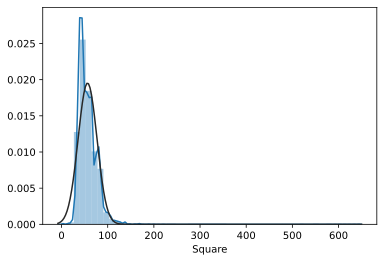

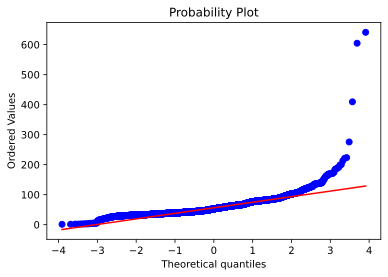

In [18]:
sns.distplot(data['Square'], fit=norm)

fig = plt.figure()
res = stats.probplot(data['Square'], plot=plt)
plt.show()

Из графика видно что все квартиры площадью до ~200 кв.м.

In [19]:
data.loc[data['Square'] > 200].nlargest(10, 'Square')

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
6977   11602          30      2  641.065186  638.163208           10.0     20   
4262      28           9      2  604.705994         NaN            1.0     17   
4690    2307         102      1  409.425171  410.639740           10.0      4   
1982    5548          86      5  275.645294  233.949310           26.0     12   
13217   4058          27      3  223.453690  104.113556           16.0      2   
13909   1397          76      1  221.138763  118.055344            4.0     32   
1981    7917          27      0  212.932358  211.231125            0.0      2   
9910   16568          27      4  200.334534  201.627365           25.0      1   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
6977           19       2019   0.000078         B         B        22   
4262           18       1977   0.161532         B         B        25   
4690            4       2016   0.238617         B         B        26   
1982           37       2011   0.161976         B         A        31   
13217          14       2017   0.041116         B         B        53   
13909           4       2011   0.000000         B         B         7   
1981            3       2008   0.211401         B         B         9   
9910            2       2013   0.041116         B         B        53   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  
6977       6398       141        1046.0             3       23       B  
4262       5648         1          30.0             2        4       B  
4690       3889         6         705.0             3        6       B  
1982       7010         5        4508.0             3        7       B  
13217     14892         4           NaN             1        4       B  
13909      1660        39        1786.0             1        5       B  
1981       1892         0           NaN             0        1       B  
9910      14892         4           NaN             1        4       B

In [20]:
def fix_square(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    
    # Жилую площадь логичнее расчитать из обoей площади квартиры. 
    # На мой взгляд это 60% от общей площади
    df['LifeSquare'] = df['LifeSquare'].fillna(df['Square']*0.6)
    
    #  Заменим все значения 0 на Nan для явного выделения дaнных
    # И аналогично с площадью кухни. Общая площадь минус жилая, минус саузлы и корридор. 
    # т.к. нет информации о сан узлах и корридоре, допустим что площадь кухни = 30% от всей нежилой
    df['KitchenSquare'] = df['KitchenSquare'].replace(0, np.nan)
    df['KitchenSquare'] = df['KitchenSquare'].fillna(round((df['Square'] - df['LifeSquare']) * 0.3, 2))
    
    return df

### replace
df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
### finder
df1 = df[(df['Square'] > 200) & (df["Rooms"] <= 3)]
### drop
df = df.drop(np.where(df['Square'] > 400)[0])
df.loc[df['Square'] > 200, 'Square']


#### Floor and House Floor

In [21]:
data.loc[data['Floor'] > data['HouseFloor'], 'Floor']

7        14
14        5
16        6
21       15
23        2
         ..
14987    13
14989    10
14992    10
14996    12
14997    23
Name: Floor, Length: 3316, dtype: uint8

In [22]:
data.loc[data['HouseFloor'] == 0, 'HouseFloor']

7        0
23       0
26       0
39       0
44       0
        ..
14878    0
14880    0
14899    0
14907    0
14947    0
Name: HouseFloor, Length: 415, dtype: uint8

In [23]:
def fix_floor(df):    
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor']
    df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] = df.loc[df['Floor'] > df['HouseFloor'], 'Floor']
    
    return df

#### HouseYear

In [24]:
data.loc[data['HouseYear'] > 2021]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814         109      1  37.265072   20.239714            9.0      9   
4189  11607         147      2  44.791836   28.360394            5.0      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497          12   20052011   0.136330         B         B        30   
4189           9       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  
1497      6141        10         262.0             3        6       B  
4189      4756        16        2857.0             5        8       B

In [25]:
def fix_house_year(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    
    return df

#### Ecology + Shops + Healthcare

In [26]:
def fix_eco_shops(df):
    df['Ecology_2'] = (df['Ecology_2'] == 'A').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'A').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'A').astype(int)
    
    return df

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             15000 non-null  uint16  
 1   DistrictId     15000 non-null  uint8   
 2   Rooms          15000 non-null  uint8   
 3   Square         15000 non-null  float32 
 4   LifeSquare     11846 non-null  float32 
 5   KitchenSquare  15000 non-null  float32 
 6   Floor          15000 non-null  uint8   
 7   HouseFloor     15000 non-null  uint8   
 8   HouseYear      15000 non-null  uint32  
 9   Ecology_1      15000 non-null  float32 
 10  Ecology_2      15000 non-null  category
 11  Ecology_3      15000 non-null  category
 12  Social_1       15000 non-null  uint8   
 13  Social_2       15000 non-null  uint16  
 14  Social_3       15000 non-null  uint8   
 15  Healthcare_1   7825 non-null   float32 
 16  Healthcare_2   15000 non-null  uint8   
 17  Shops_1        15000 non-null  

In [50]:
def all_fix(df):
    df = fix_rooms(df)
    df = fix_square(df)
    df = fix_floor(df)
    df = fix_house_year(df)
    df = pd.get_dummies(df)
    
    healthcare_1_mode = df['Healthcare_1'].mode()
    df['Healthcare_1'] = df['Healthcare_1'].fillna(healthcare_1_mode[0])
    
    reduce_mem_usage(df)
        
    return df

### Исправление исходных данных закончилось, теперь анализ данных.

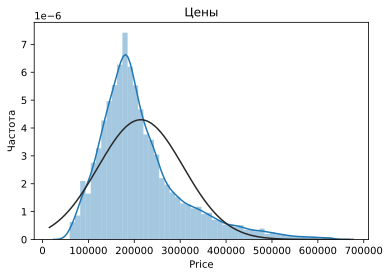

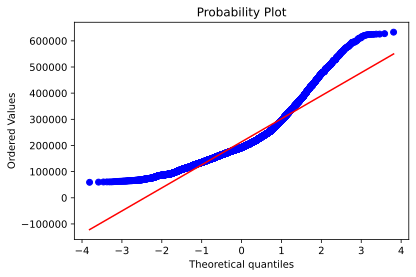

In [29]:
sns.distplot(train['Price'], fit=norm)
plt.ylabel('Частота')
plt.title('Цены')

fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

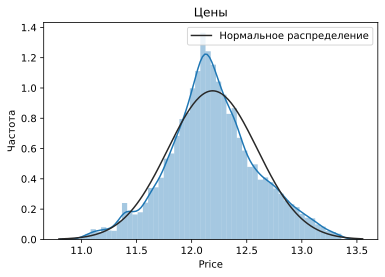

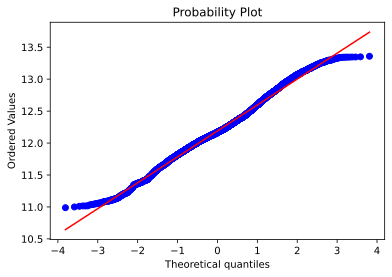

In [30]:
price_log = np.log1p(train['Price'])
sns.distplot(price_log, fit=norm)
plt.legend(['Нормальное распределение'], loc='best')
plt.ylabel('Частота')
plt.title('Цены')

fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

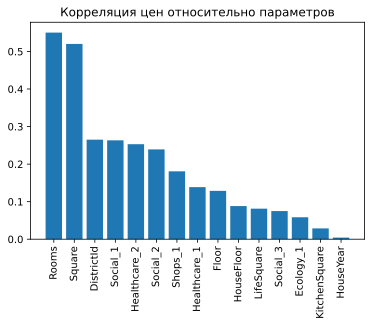

In [31]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Корреляция цен относительно параметров')
plt.xticks(rotation='vertical')
plt.show()

Text(0.5, 1.0, 'Отношение цены к Social_1')

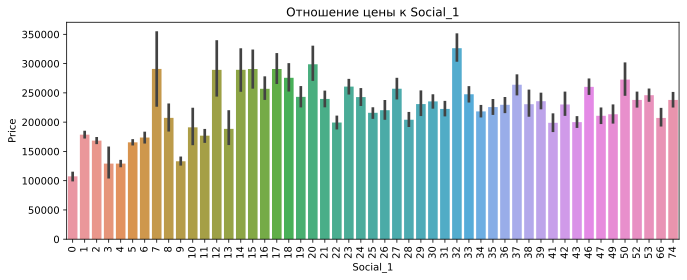

In [32]:
plt.figure(figsize=(11, 4))
sns.barplot(data=train, x='Social_1', y='Price')
plt.xticks(rotation=90)
plt.title('Отношение цены к Social_1')

Text(0.5, 1.0, 'Отношение цены к HouseFloor')

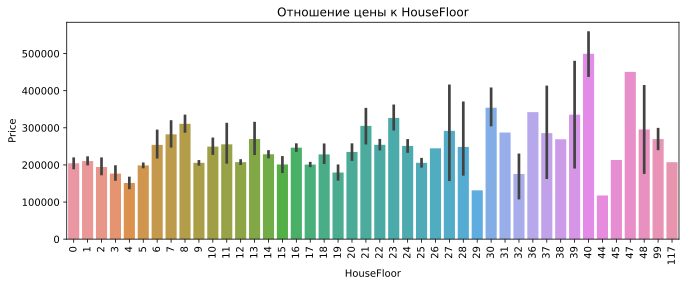

In [33]:
plt.figure(figsize=(11, 4))
sns.barplot(data=train, x='HouseFloor', y='Price')
plt.xticks(rotation=90)
plt.title('Отношение цены к HouseFloor')

Text(0.5, 1.0, 'Отношение цены к году постройки дома')

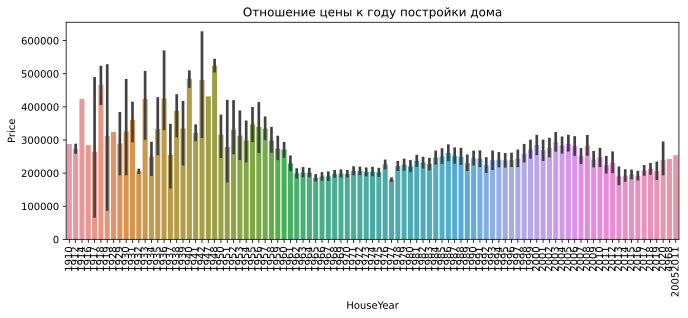

In [34]:
plt.figure(figsize=(11, 4))
sns.barplot(data=train, x='HouseYear', y='Price')
plt.xticks(rotation=90)
plt.title('Отношение цены к году постройки дома')

Text(0.5, 1.0, 'Отношение цены к району')

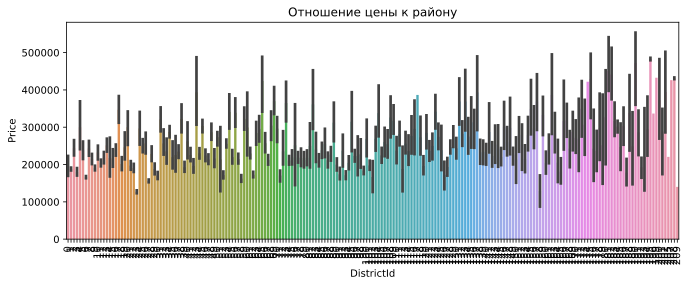

In [35]:
plt.figure(figsize=(11, 4))
sns.barplot(data=train, x='DistrictId', y='Price')
plt.xticks(rotation=90)
plt.title('Отношение цены к району')

#### Строим модель для предсказания цен на недвижимость (квартиры)

In [37]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)
target = 'Price'

# x = train.drop([target, 'Id'], axis=1)
# x = all_fix(x)
# y = train[target]

In [38]:
train[features].head(10)

Rooms     Square  DistrictId  Social_1  Healthcare_2  Social_2  Shops_1  \
0      2  47.981560          35        33             0      7976       11   
1      3  65.683640          41        46             1     10309       16   
2      2  44.947952          53        34             1      7759        3   
3      2  53.352982          58        23             0      5735        5   
4      1  39.649193          99        35             2      5776        4   
5      3  80.384476          59        35             0      7715        6   
6      2  62.254112         154        20             1      4386        5   
7      2  80.312927          74         6             0      1437        2   
8      2  64.511436           1         1             0       264        1   
9      1  46.461411          23         6             0      1437        2   

   Healthcare_1  Floor  HouseFloor  LifeSquare  Social_3  Ecology_1  \
0           NaN      7           9   29.442751         5   0.089040   
1         240.0      7           9   40.049541         1   0.000070   
2         229.0      8          12   29.197611         0   0.049637   
3        1084.0      8          17   52.731510         3   0.437885   
4        2078.0     11          12   23.776169         1   0.012339   
5         990.0      5          17   46.683720         4   0.309479   
6           NaN      3           5   37.160378        14   0.460556   
7           NaN     14           0         NaN         3   0.075779   
8           NaN      9          17         NaN         0   0.007122   
9           NaN     13          17   18.915552         3   0.075779   

   KitchenSquare  HouseYear  
0            6.0       1969  
1            8.0       1978  
2            0.0       1968  
3            9.0       1977  
4            7.0       1976  
5           12.0       2011  
6            7.0       1960  
7            0.0       1977  
8            1.0       1977  
9            8.0       2014

In [39]:
train[target].head()

0    184966.937500
1    300009.437500
2    220925.906250
3    175616.234375
4    150226.531250
Name: Price, dtype: float32

In [41]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.3, random_state=42)

In [47]:
x_train.head()

Rooms      Square  DistrictId  Social_1  Healthcare_2  Social_2  \
9069      1   41.681381          23         6             0      1437   
2603      3  163.495331          23         2             0       475   
7738      1   39.710133          87        43             1      7227   
1579      3   96.056786          48        46             1      9515   
5058      3   79.195824          77        16             1      4048   

      Shops_1  Healthcare_1  Floor  HouseFloor  LifeSquare  Social_3  \
9069        2           NaN     14          17   22.796165         3   
2603        0           NaN      5           5  161.504227         0   
7738        6           NaN      4          17   19.538664         0   
1579       10           NaN     15          15   96.056786         5   
5058        3           NaN     16          17   44.421062         3   

      Ecology_1  KitchenSquare  HouseYear  
9069   0.075779            8.0       2015  
2603   0.014073           12.0       1977  
7738   0.100456            8.0       1986  
1579   0.041125            1.0       2017  
5058   0.298205           10.0       1984

In [51]:
x_train = all_fix(x_train)
x_test = all_fix(x_test)

In [52]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          7000 non-null   uint8  
 1   Square         7000 non-null   float32
 2   DistrictId     7000 non-null   uint8  
 3   Social_1       7000 non-null   uint8  
 4   Healthcare_2   7000 non-null   uint8  
 5   Social_2       7000 non-null   uint16 
 6   Shops_1        7000 non-null   uint8  
 7   Healthcare_1   7000 non-null   float32
 8   Floor          7000 non-null   uint8  
 9   HouseFloor     7000 non-null   uint8  
 10  LifeSquare     7000 non-null   float32
 11  Social_3       7000 non-null   uint8  
 12  Ecology_1      7000 non-null   float32
 13  KitchenSquare  7000 non-null   float32
 14  HouseYear      7000 non-null   uint16 
dtypes: float32(5), uint16(2), uint8(8)
memory usage: 273.4 KB


In [53]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 6252 to 4705
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          3000 non-null   uint8  
 1   Square         3000 non-null   float32
 2   DistrictId     3000 non-null   uint8  
 3   Social_1       3000 non-null   uint8  
 4   Healthcare_2   3000 non-null   uint8  
 5   Social_2       3000 non-null   uint16 
 6   Shops_1        3000 non-null   uint8  
 7   Healthcare_1   3000 non-null   float32
 8   Floor          3000 non-null   uint8  
 9   HouseFloor     3000 non-null   uint8  
 10  LifeSquare     3000 non-null   float32
 11  Social_3       3000 non-null   uint8  
 12  Ecology_1      3000 non-null   float32
 13  KitchenSquare  3000 non-null   float32
 14  HouseYear      3000 non-null   uint16 
dtypes: float32(5), uint16(2), uint8(8)
memory usage: 117.2 KB


In [54]:
x_train.head()

Rooms      Square  DistrictId  Social_1  Healthcare_2  Social_2  \
9069      1   41.681381          23         6             0      1437   
2603      3  163.495331          23         2             0       475   
7738      1   39.710133          87        43             1      7227   
1579      3   96.056786          48        46             1      9515   
5058      3   79.195824          77        16             1      4048   

      Shops_1  Healthcare_1  Floor  HouseFloor  LifeSquare  Social_3  \
9069        2         540.0     14          17   22.796165         3   
2603        0         540.0      5           5  161.504227         0   
7738        6         540.0      4          17   19.538664         0   
1579       10         540.0     15          15   96.056786         5   
5058        3         540.0     16          17   44.421062         3   

      Ecology_1  KitchenSquare  HouseYear  
9069   0.075779            8.0       2015  
2603   0.014073           12.0       1977  
7738   0.100456            8.0       1986  
1579   0.041125            1.0       2017  
5058   0.298205           10.0       1984

In [55]:
y_train.head()

9069     88504.382812
2603    207007.953125
7738    182126.281250
1579    524365.562500
5058    322048.437500
Name: Price, dtype: float32

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

In [57]:
# model = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state = 42)
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [58]:
y_pred = model.predict(x_test)

In [59]:
check_test = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_pred.flatten(),
    'deviation': y_test.values - y_pred.flatten(),
    '%': abs(100 - (y_pred.flatten() * 100 / y_test.values))
})

check_test.head()

y_test         y_pred     deviation          %
0  181530.453125  180143.048906   1387.404219   0.764282
1  260456.000000  287780.333828 -27324.333828  10.490960
2  219945.296875  213093.235313   6852.061562   3.115348
3   66883.281250   67668.596367   -785.315117   1.174158
4  114086.062500  123226.680547  -9140.618047   8.012037

In [60]:
from sklearn.metrics import r2_score

R2_2 = r2_score(check_test["y_pred"], check_test["y_test"])

print(f'R2 = {R2_2}')

R2 = 0.6116292876664757


### Работа с файлом test.csv

In [61]:
test = all_fix(test)

In [62]:
test[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   uint8  
 1   Square         5000 non-null   float32
 2   DistrictId     5000 non-null   uint8  
 3   Social_1       5000 non-null   uint8  
 4   Healthcare_2   5000 non-null   uint8  
 5   Social_2       5000 non-null   uint16 
 6   Shops_1        5000 non-null   uint8  
 7   Healthcare_1   5000 non-null   float32
 8   Floor          5000 non-null   uint8  
 9   HouseFloor     5000 non-null   uint8  
 10  LifeSquare     5000 non-null   float32
 11  Social_3       5000 non-null   uint8  
 12  Ecology_1      5000 non-null   float32
 13  KitchenSquare  5000 non-null   float32
 14  HouseYear      5000 non-null   uint16 
dtypes: float32(5), uint16(2), uint8(8)
memory usage: 156.4 KB


In [63]:
test[features].head()

Rooms     Square  DistrictId  Social_1  Healthcare_2  Social_2  Shops_1  \
0      2  49.882645          58        11             0      2748        0   
1      3  69.263184          74         6             0      1437        2   
2      2  13.597818         190        30             5      7538        5   
3      2  73.046608          47        23             3      4583        3   
4      1  47.527111          27         2             0       629        0   

   Healthcare_1  Floor  HouseFloor  LifeSquare  Social_3  Ecology_1  \
0         540.0      6           9   33.432781         1   0.310199   
1         540.0      6           9   41.557911         3   0.075779   
2        4702.0      2          12   13.597818        87   0.000000   
3         540.0     22          22   51.940842         3   0.101872   
4         540.0     17          17   43.387569         1   0.072158   

   KitchenSquare  HouseYear  
0            6.0       1972  
1            1.0       1977  
2           12.0       1909  
3            9.0       2007  
4            1.0       2017

In [64]:
test['Price'] = model.predict(test[features])

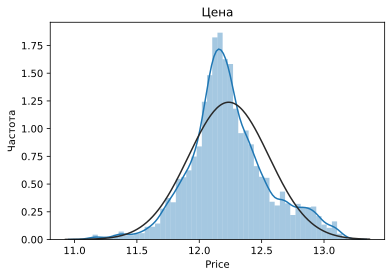

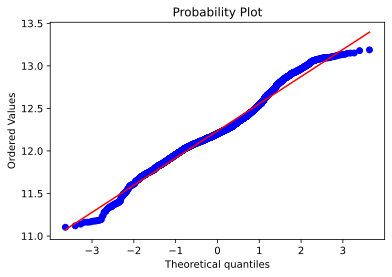

In [65]:
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)
plt.ylabel('Частота')
plt.title('Цена')

fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [66]:
test.to_csv('IIZakharov_predictions.csv', index=None)

In [67]:
test.head(10)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58      2  49.882645   33.432781            6.0      6   
1  15856          74      3  69.263184   41.557911            1.0      6   
2   5480         190      2  13.597818   13.597818           12.0      2   
3  15664          47      2  73.046608   51.940842            9.0     22   
4  14275          27      1  47.527111   43.387569            1.0     17   
5   7633          53      3  40.675625   24.405376            1.0     21   
6  13329          23      2  68.099541   64.843025            1.0      2   
7   5502          32      2  48.193897   32.857643            6.0      5   
8   4220          96      2  72.277107   45.968758            9.0     17   
9  11538           6      1  80.219398   47.660259            9.0     13   

   HouseFloor  HouseYear  Ecology_1  ...  Healthcare_1  Healthcare_2  Shops_1  \
0           9       1972   0.310199  ...         540.0             0        0   
1           9       1977   0.075779  ...         540.0             0        2   
2          12       1909   0.000000  ...        4702.0             5        5   
3          22       2007   0.101872  ...         540.0             3        3   
4          17       2017   0.072158  ...         540.0             0        0   
5          21       1977   0.049637  ...         229.0             1        3   
6           5       1977   0.075779  ...         540.0             0        2   
7           5       1972   0.135650  ...         350.0             3       11   
8          17       1997   0.041116  ...         540.0             1        4   
9          17       2014   0.243205  ...         540.0             0        0   

   Ecology_2_A  Ecology_2_B  Ecology_3_A  Ecology_3_B  Shops_2_A  Shops_2_B  \
0            0            1            0            1          0          1   
1            0            1            0            1          0          1   
2            0            1            0            1          0          1   
3            0            1            0            1          0          1   
4            0            1            0            1          1          0   
5            0            1            0            1          0          1   
6            0            1            0            1          0          1   
7            0            1            0            1          0          1   
8            0            1            0            1          0          1   
9            0            1            0            1          0          1   

           Price  
0  163401.639297  
1  223429.090156  
2  337105.169453  
3  364326.579375  
4  143432.897500  
5  209224.944922  
6  175966.907344  
7  211345.817188  
8  277962.943672  
9  202472.798906  

[10 rows x 23 columns]